In [13]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import os

In [14]:
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred, average='macro'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    labels = np.unique(np.concatenate([y_true, y_pred]))
    per_class = {}
    precisions = []
    recalls = []
    f1s = []
    for lab in labels:
        tp = np.sum((y_true == lab) & (y_pred == lab))
        fp = np.sum((y_true != lab) & (y_pred == lab))
        fn = np.sum((y_true == lab) & (y_pred != lab))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        per_class[lab] = (prec, rec, f1)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    macro_p = np.mean(precisions)
    macro_r = np.mean(recalls)
    macro_f1 = np.mean(f1s)
    return {
        'per_class': per_class,
        'macro_precision': macro_p,
        'macro_recall': macro_r,
        'macro_f1': macro_f1
    }


In [15]:
def print_metrics(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_recall_f1(y_true, y_pred)
    print(f"--- {name} Metrics ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {pr['macro_precision']:.4f}")
    print(f"Macro Recall: {pr['macro_recall']:.4f}")
    print(f"Macro F1: {pr['macro_f1']:.4f}")
    print("Per-class (precision, recall, f1):")
    for k, v in sorted(pr['per_class'].items()):
        print(f"  {k}: {v[0]:.4f}, {v[1]:.4f}, {v[2]:.4f}")
    print()


In [16]:
def load_mnist_csv(path):
    df = pd.read_csv(path)
    if 'label' in df.columns:
        # Training data
        y = df['label'].values
        X = df.drop(columns=['label']).values
    else:
        # Test data (no labels)
        y = np.zeros(df.shape[0], dtype=int)  # dummy placeholder
        X = df.values

    print(f"Loaded {path}: X.shape={X.shape}, y.shape={y.shape}")
    return X.astype(np.float32), y.astype(int)


In [17]:
def one_hot(y, num_classes):
    y = np.array(y, dtype=int)
    oh = np.zeros((y.shape[0], num_classes), dtype=float)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)  # stability
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_onehot):
    # average negative log-likelihood
    eps = 1e-12
    logp = np.log(probs + eps)
    return -np.mean(np.sum(y_onehot * logp, axis=1))


In [18]:
class SoftmaxRegression:
    def __init__(self, num_features, num_classes, lr=0.1, reg=0.0):
        self.W = np.zeros((num_features, num_classes), dtype=float)  # shape D x C
        self.b = np.zeros((1, num_classes), dtype=float)
        self.lr = lr
        self.reg = reg

    def predict_proba(self, X):
        logits = X.dot(self.W) + self.b  # N x C
        return softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def fit(self, X, y, epochs=100, batch_size=None, verbose=True):
        N, D = X.shape
        C = np.max(y) + 1
        y_oh = one_hot(y, C)
        if batch_size is None:
            batch_size = N  # full batch gradient descent
        for epoch in range(1, epochs + 1):
            # simple batching (no shuffling for determinism)
            perm = np.arange(N)
            np.random.shuffle(perm)
            for i in range(0, N, batch_size):
                batch_idx = perm[i:i+batch_size]
                Xb = X[batch_idx]
                yb = y_oh[batch_idx]
                probs = self.predict_proba(Xb)
                # gradient of loss wrt logits: (probs - y)
                grad_logits = (probs - yb) / Xb.shape[0]  # B x C
                gradW = Xb.T.dot(grad_logits) + self.reg * self.W
                gradb = np.sum(grad_logits, axis=0, keepdims=True)
                # update
                self.W -= self.lr * gradW
                self.b -= self.lr * gradb
            if verbose and (epoch % max(1, epochs//10) == 0 or epoch==1):
                train_loss = cross_entropy_loss(self.predict_proba(X), y_oh)
                train_acc = accuracy_score(y, self.predict(X))
                print(f"Epoch {epoch}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f}")


In [19]:
def array_to_image(arr, normalize=True, size=(28,28)):
    a = np.array(arr).reshape(size)
    if normalize:
        # scale to 0-255
        amin, amax = a.min(), a.max()
        if amax > 1.0:
            # assume 0-255
            norm = np.clip(a, 0, 255).astype(np.uint8)
        else:
            # assume 0-1
            norm = np.clip((a - amin) / (amax - amin + 1e-12) * 255, 0, 255).astype(np.uint8)
    else:
        norm = np.clip(a, 0, 255).astype(np.uint8)
    return Image.fromarray(norm)


In [20]:
def predict_sample(sample_array, model, normalize_input=True, show=False):
    x = np.array(sample_array).reshape(1, -1).astype(float)
    if normalize_input:
        # normalize to [0,1]
        if x.max() > 1.0:
            x = x / 255.0
    probs = model.predict_proba(x)
    pred = int(np.argmax(probs))
    img = array_to_image(x.reshape(-1) if normalize_input else x.reshape(-1), normalize=True)
    if show:
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {pred}")
        plt.axis('off')
        plt.show()
    return img, pred


In [21]:
class MixedNaiveBayes:
    def __init__(self, categorical_features=None, numeric_features=None, laplace=1.0):
        self.cat_feats = categorical_features or []
        self.num_feats = numeric_features or []
        self.laplace = laplace
        self.class_priors = {}
        self.cat_cond_probs = {}  # (feat, value, class) -> logprob
        self.num_stats = {}  # (feat, class) -> (mean, var)
        self.classes_ = None

    def fit(self, X_df, y_series):
        df = X_df.copy()
        y = np.array(y_series)
        classes, counts = np.unique(y, return_counts=True)
        self.classes_ = classes
        total = y.shape[0]
        # priors (log)
        self.class_priors = {c: np.log(counts[i] / total) for i, c in enumerate(classes)}
        # categorical conditional probs
        for feat in self.cat_feats:
            values = df[feat].astype(str).values
            for c in classes:
                mask = (y == c)
                subset = values[mask]
                counter = Counter(subset)
            feat_vals = df[feat].astype(str).unique()
            V = len(feat_vals)
            for c in classes:
                mask = (y == c)
                subset = df.loc[mask, feat].astype(str).values
                cnt = Counter(subset)
                denom = len(subset) + self.laplace * V
                for v in feat_vals:
                    num = cnt.get(v, 0) + self.laplace
                    self.cat_cond_probs[(feat, v, c)] = np.log(num / denom)
        # numeric stats
        for feat in self.num_feats:
            for c in classes:
                vals = df.loc[y == c, feat].astype(float).values
                if vals.size == 0:
                    mean = 0.0
                    var = 1.0
                else:
                    mean = np.mean(vals)
                    var = np.var(vals) + 1e-9
                self.num_stats[(feat, c)] = (mean, var)

    def _log_likelihood(self, x_row):
        log_probs = {}
        for c in self.classes_:
            lp = self.class_priors[c]
            # categorical
            for feat in self.cat_feats:
                val = str(x_row[feat])
                key = (feat, val, c)
                if key in self.cat_cond_probs:
                    lp += self.cat_cond_probs[key]
                else:
                    lp += np.log(self.laplace * 1e-3)
            # numeric
            for feat in self.num_feats:
                mean, var = self.num_stats[(feat, c)]
                x = float(x_row[feat])
                # gaussian log prob
                lp += -0.5 * np.log(2 * np.pi * var) - ((x - mean) ** 2) / (2 * var)
            log_probs[c] = lp
        return log_probs

    def predict(self, X_df):
        preds = []
        for _, row in X_df.iterrows():
            lps = self._log_likelihood(row)
            # pick class with max log prob
            pred = max(lps.items(), key=lambda kv: kv[1])[0]
            preds.append(pred)
        return np.array(preds)


In [22]:
def prepare_mnist_and_train(train_csv='MNIST_data/train.csv', test_csv='MNIST_data/test.csv',
                            lr=0.5, epochs=100, batch_size=128, reg=0.0):
    print("Loading MNIST data...")
    X_train, y_train = load_mnist_csv(train_csv)
    X_test, y_test = load_mnist_csv(test_csv)
    # normalize to [0,1]
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    # initialize model
    num_features = X_train.shape[1]
    num_classes = int(np.max(y_train)) + 1
    model = SoftmaxRegression(num_features, num_classes, lr=lr, reg=reg)
    print("Training softmax regression...")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=True)
    print("Predicting test set...")
    y_pred = model.predict(X_test)
    print_metrics(y_test, y_pred, name="MNIST SoftmaxRegression")
    return model, X_test, y_test, y_pred

def prepare_bank_and_train(bank_csv=r"C:\Users\dubey\OneDrive\Desktop\Coding\ML_Lab\Lab9\bank-full.csv", train_indices_file=None, test_indices_file=None,
                           numeric_threshold=15):
    print("Loading bank-full data...")
    df = pd.read_csv(bank_csv, sep=';')
    # target column 'y' typically has 'yes'/'no' strings
    if 'y' not in df.columns:
        raise ValueError("Expected column 'y' in bank-full.csv")
    y = df['y'].values
    X = df.drop(columns=['y'])

    # if index files provided and exist, use them
    if train_indices_file and test_indices_file and os.path.exists(train_indices_file) and os.path.exists(test_indices_file):
        print("Using provided train/test index files.")
        train_idx = np.load(train_indices_file)
        test_idx = np.load(test_indices_file)
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y[train_idx]
        X_test = X.iloc[test_idx].reset_index(drop=True)
        y_test = y[test_idx]
    else:
        # create reproducible stratified split (70/30)
        print("No split files found, creating reproducible stratified split (70/30) with random_state=42.")
        from sklearn.model_selection import StratifiedShuffleSplit
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
        for train_idx, test_idx in splitter.split(X, y):
            X_train = X.iloc[train_idx].reset_index(drop=True)
            y_train = y[train_idx]
            X_test = X.iloc[test_idx].reset_index(drop=True)
            y_test = y[test_idx]

    numeric_feats = []
    categorical_feats = []
    for col in X_train.columns:
        if pd.api.types.is_numeric_dtype(X_train[col]):
            numeric_feats.append(col)
        else:
            uniques = X_train[col].nunique()
            if uniques > numeric_threshold:
                try:
                    X_train[col].astype(float)
                    numeric_feats.append(col)
                    continue
                except:
                    categorical_feats.append(col)
            else:
                categorical_feats.append(col)

    print("Numeric features:", numeric_feats)
    print("Categorical features:", categorical_feats)

    model = MixedNaiveBayes(categorical_features=categorical_feats, numeric_features=numeric_feats, laplace=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metrics(y_test, y_pred, name="Bank-full MixedNaiveBayes")
    return model, X_test, y_test, y_pred


Loading MNIST data...
Loaded MNIST_data/train.csv: X.shape=(42000, 784), y.shape=(42000,)
Loaded MNIST_data/test.csv: X.shape=(28000, 784), y.shape=(28000,)
Training softmax regression...
Epoch 1/50 - loss: 0.3812 - acc: 0.8865
Epoch 5/50 - loss: 0.2852 - acc: 0.9200
Epoch 10/50 - loss: 0.2668 - acc: 0.9257
Epoch 15/50 - loss: 0.2766 - acc: 0.9214
Epoch 20/50 - loss: 0.2702 - acc: 0.9226
Epoch 25/50 - loss: 0.2594 - acc: 0.9265
Epoch 30/50 - loss: 0.2522 - acc: 0.9297
Epoch 35/50 - loss: 0.2510 - acc: 0.9293
Epoch 40/50 - loss: 0.2493 - acc: 0.9288
Epoch 45/50 - loss: 0.2823 - acc: 0.9140
Epoch 50/50 - loss: 0.2466 - acc: 0.9286
Predicting test set...
--- MNIST SoftmaxRegression Metrics ---
Accuracy: 0.1008
Macro Precision: 0.1000
Macro Recall: 0.0101
Macro F1: 0.0183
Per-class (precision, recall, f1):
  0: 1.0000, 0.1008, 0.1831
  1: 0.0000, 0.0000, 0.0000
  2: 0.0000, 0.0000, 0.0000
  3: 0.0000, 0.0000, 0.0000
  4: 0.0000, 0.0000, 0.0000
  5: 0.0000, 0.0000, 0.0000
  6: 0.0000, 0.000

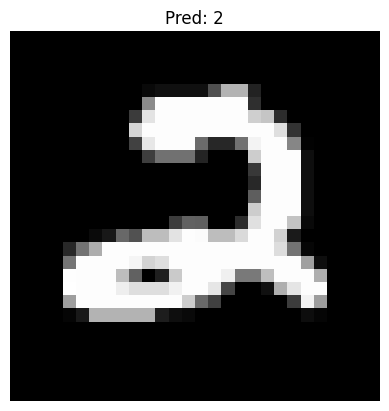

Predicted label for first test sample: 2
Loading bank-full data...
No split files found, creating reproducible stratified split (70/30) with random_state=42.
Numeric features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
--- Bank-full MixedNaiveBayes Metrics ---
Accuracy: 0.8799
Macro Precision: 0.7113
Macro Recall: 0.7210
Macro F1: 0.7160
Per-class (precision, recall, f1):
  no: 0.9351, 0.9284, 0.9318
  yes: 0.4874, 0.5135, 0.5002



In [23]:
mnist_model, X_test_mnist, y_test_mnist, y_pred_mnist = prepare_mnist_and_train(
    lr=0.5, epochs=50, batch_size=256, reg=1e-4
)
img, lab = predict_sample(X_test_mnist[0]*255.0, mnist_model, normalize_input=True, show=True)
print("Predicted label for first test sample:", lab)

bank_model, X_test_bank, y_test_bank, y_pred_bank = prepare_bank_and_train(
    train_indices_file="bank_train_indices.npy",
    test_indices_file="bank_test_indices.npy"
)
